# `utils_videos`

In [ ]:
#| default_exp utils_videos

In [ ]:
#| export
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np
import imageio

# Deeptrack is not automatically installed in andi_datasets
# due to its load. 
import warnings
try:
    # First, avoid unnecessary warnings from tf
    import os
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
    import deeptrack as dt
except:
    warnings.warn('From your imports it seems that you will need Deeptrack. Install if needed using pip install deeptrack.')

/home/gorka/miniconda3/envs/andi/lib/python3.10/site-packages/deeptrack/backend/_config.py:11: UserWarning: cupy not installed. GPU-accelerated simulations will not be possible
  warnings.warn(
/home/gorka/miniconda3/envs/andi/lib/python3.10/site-packages/deeptrack/backend/_config.py:25: UserWarning: cupy not installed, CPU acceleration not enabled
  warnings.warn("cupy not installed, CPU acceleration not enabled")


# Helpers for videos

In [ ]:
#| export
def play_video(video, figsize=(5, 5), fps=10):
    """
    Displays a stack of images as a video inside jupyter notebooks.

    Parameters
    ----------
    video : ndarray
        Stack of images.
    figsize : tuple, optional
        Canvas size of the video.
    fps : int, optional
        Video frame rate.

    Returns
    -------
    Video object
        Returns a video player with input stack of images.
    """
    fig = plt.figure(figsize=figsize)
    images = []
    plt.axis("off")

    for image in video:
        images.append([plt.imshow(image[:, :, 0], cmap="gray")])

    anim = animation.ArtistAnimation(
        fig, images, interval=1e3 / fps, blit=True, repeat_delay=0
    )

    html = HTML(anim.to_jshtml())
    display(html)
    plt.close()

In [ ]:
#| export
def convert_uint8(vid, with_vips = False):
    """
    Converts a stack of images in to 8bit pixel format.
    
    This is a helper function for  `transform_to_video`

    Parameters
    ----------
    vid : ndarray
        Stack of images.
    with_vips: bool, optional
        Appends a mask of vip particles in the first frame to the converted video.
    
    Returns
    -------
    ndarray
        Image stack in 8bit.
    """
    new_vid = []
    for idx_im, im in enumerate(vid):
        if idx_im == 0 and with_vips:
            im[im == -1] = 255
            new_vid.append(im.astype(np.uint8))
        else:            
            im = im[:,:,0]
            im = im / im.max()
            im = im * 255
            im = im.astype(np.uint8)
            new_vid.append(im)
    return new_vid

In [ ]:
#| export
def psf_width(NA = 1.46, wavelength = 500e-9, resolution = 100e-9):
    """
    Computes the PSF full width at half maximum (FWHM).

    This is a helper function for `transform_to_video`
    
    Parameters
    ----------
    NA : float
        Numerical aperture.
    wavelength : float
        Wavelength.
    resolution : float
        Resolution of the camera.
    
    Returns
    -------
    int
        PSF width in pixels.
    """
    _psf = 1.22 * wavelength / (2 * NA)
    return _psf / resolution

In [ ]:
#| export
def func_poisson_noise():
    """
    Applies poisson noise to an image.

    This is a custom DeepTrack feature, and a helper function for `transform_to_video`
    """
    def inner(image):
        image[image<0] = 0
        rescale = 1
        noisy_image = np.random.poisson(image * rescale) / rescale
        return noisy_image
    return inner

In [ ]:
#| export
def mask(circle_radius, particle_list=[]):
    """
    Computes binary masks for particles in microscopy videos.

    This is a custom DeepTrack feature, and a helper function for `transform_to_video`.

    Parameters
    ----------
    particle_list: list of int
        List of particles whose masks need to be created

    """
    def inner(image):
        X, Y = np.mgrid[:2*circle_radius, :2*circle_radius]
        CIRCLE = (X - circle_radius+0.5)**2 + (Y- circle_radius+0.5)**2 < circle_radius**2
        CIRCLE = np.expand_dims(CIRCLE, axis=-1)
        _index = image.get_property("replicate_index")[0]
        if particle_list:
            if _index in particle_list:
                pix_val = (_index + 1) * CIRCLE
            else:
                pix_val = 0 * CIRCLE
        else:
            pix_val = (_index + 1) * CIRCLE
        return pix_val
    return inner

# `transform_to_video`

In [ ]:
#| export
def transform_to_video(
    trajectory_data,
    particle_props={},
    optics_props={},
    background_props={},
    get_vip_particles=[],
    with_masks=False,
    save_video=False,
    path="",
    motion_blur_generator = None
):
    """
    Transforms trajectory data into microscopy imagery data.

    Trajectories generated through phenomenological models in andi-datasets are imaged under a Fluorescence microscope to generate 2D timelapse videos.

    Parameters
    ----------
    trajectory_data : ndarray
        Generated through models_phenom. Array of the shape (T, N, 2) containing the trajectories.
    particle_props : dict
        Dictionary containing the properties of particles to be simulated as keyword arguments. Valid keys are:

            '`particle_intensity`' : array_like[int, int]
                Intensity distribution of particles within a frame given as mean and standard deviations.

            '`intensity_variation`' : int
                Intensity variation of particles in subsequent frames given as standard deviation.

            '`z`' : float
                Particle positions with respect to the focal plane in pixel units defined by the pixel size in **optics_props**. For example, particles will be at focus when `z=0`.

            '`refractive_index`' : float
                Refractive index of particle.

    optics_props : dict
        Dictionary containing the properties of microscope as keyword arguments. Valid keys are:

            '`NA`': float
                Numerical aperture of the microscope.

            '`wavelength`' : float
                Wavelength of light in meters.

            '`resolution`' : float
                Effective pixel size of the camera in meters.

            '`magnification`' : float
                Magnification of the optical system.

            '`refractive_index_medium`' : float
                Refractive index of the medium sorrounding the particles.

            '`output_region`': array_like[int, int, int, int]
                ROI of the image to output.
                Given in the format : [x, y, x + width, y + height].

    background_props : dict
        Dictionary containing properties related to background intensity as keyword arguments. Valid keys are:

            '`background_mean`' : int
                Mean background intensity.

            '`backgound_std`' : int
                Standard deviation of the background intesity with subsequent frames of a video.

    get_vip_particles : list of int
        List of particles for which the masks are needed in the output.

    with_masks : bool
        If True, particle masks are returned in the output along with the video.
        If False (default), only the video is returned in the output.

    save_video : bool
        If True, the generated video will be saved at the given path.
    path : str
        File path for saving the video, the path should be given along the video format.
        For example: 'path' = './video.mp4' will save the video in the current folder.

    Returns
    -------
    tuple | ndarray

        Output type I 

        If `with_masks = True`,
        The function returns a tuple containing:
            masks : ndarray
            video : ndarray
        Note: If `get_vip_particles` is a non-empty list, the masks will contain only the vip particle masks.

        Output type II

        If `with_masks = False`,
        The function returns:
            video : ndarray
        Note: If `get_vip_particles` is a non-empty list, the first frame in the output will be the masks of the given vip particles in the first frame, else (default) the output will be a ndarray of just the video.

    """

    _particle_dict = {
        "particle_intensity": [
            500,
            20,
        ],  # Mean and standard deviation of the particle intensity
        "intensity": lambda particle_intensity: particle_intensity[0]
        + np.random.randn() * particle_intensity[1],
        "intensity_variation": 0,  # Intensity variation of particle (in standard deviation)
        # "z": 0,  # Particles are always at focus
        "refractive_index": 1.45,  # Refractive index of the particle
        "position_unit": "pixel",
    }

    _optics_dict = {
        "NA": 1.46,  # Numerical aperture
        "wavelength": 500e-9,  # Wavelength
        "resolution": 100e-9,  # Camera resolution or effective resolution
        "magnification": 1,
        "refractive_index_medium": 1.33,
        "output_region": [0, 0, 128, 128],
    }

    # Background offset
    _background_dict = {
        "background_mean": 100,  # Mean background intensity
        "background_std": 0,  # Standard deviation of background intensity within a video
    }

    # Update the dictionaries with the user-defined values
    _particle_dict.update(particle_props)
    _optics_dict.update(optics_props)
    _background_dict.update(background_props)

    # Reshape the trajectory
    trajectory_data = np.moveaxis(trajectory_data, 0, 1)

    # Generate point particles
    particle = dt.PointParticle(
        trajectories=trajectory_data,
        replicate_index=lambda _ID: _ID,
        trajectory=lambda replicate_index, trajectories: dt.units.pixel
        * trajectories[replicate_index[-1]],
        number_of_particles=trajectory_data.shape[0],
        traj_length=trajectory_data.shape[1],
        position=lambda trajectory: trajectory[0, :2],
        z=lambda trajectory: trajectory[0, -1] if trajectory.shape[-1] == 3 else 0,
        **_particle_dict,
    )

    # Intensity variation of particles - controlled by "intensity_variation"
    def intensity_noise(previous_values, previous_value):
        return (previous_values or [previous_value])[0] + _particle_dict[
            "intensity_variation"
        ] * np.random.randn()

    # Make it sequential
    sequential_particle = dt.Sequential(
        particle,
        position=lambda trajectory, sequence_step: trajectory[sequence_step, :2],
        z=lambda trajectory, sequence_step: trajectory[sequence_step, -1] if trajectory.shape[-1] == 3 else 0,
        intensity=intensity_noise,
    )

    # Adding background offset
    background = dt.Add(
        value=_background_dict["background_mean"]
        + np.random.randn() * _background_dict["background_std"]
    )

    def background_variation(previous_values, previous_value):
        return (previous_values or [previous_value])[
            0
        ] + np.random.randn() * _background_dict["background_std"]

    ## This will change the background offset within a sequence with a given standard deviation
    sequential_background = dt.Sequential(background, value=background_variation)

    # Define optical setup
    optics = dt.Fluorescence(**_optics_dict)

    # Normalising image plane particle intensity
    scale_factor = (
        (
            optics.magnification()
            * optics.wavelength()
            / (optics.NA() * optics.resolution())
        )
        ** 2
    ) * (1 / np.pi)
    scale_factor = 4 * np.sqrt(scale_factor) # Scaling to the peak value

    # Poisson noise
    poisson_noise = dt.Lambda(func_poisson_noise)

    # Sample
    sample = (
        optics(sequential_particle ^ sequential_particle.number_of_particles)
        >> (dt.Multiply(scale_factor) if not motion_blur_generator else dt.Multiply(1)) # Scaling is done later for motion blur
        >> sequential_background
        >> (poisson_noise if not motion_blur_generator else dt.Multiply(1)) # Noise is added later for motion blur
    )

    # Masks
    get_masks = dt.SampleToMasks(
        lambda: mask(circle_radius=1, particle_list=get_vip_particles),
        output_region=optics.output_region,
        merge_method="add",
    )

    masks = sample >> get_masks >> dt.Add(-1)

    # Sequential sample
    sequential_sample = dt.Sequence(
        (sample & masks),
        trajectory=particle.trajectories,
        sequence_length=particle.traj_length,
    )

    # Resolve the sample
    video, masks = sequential_sample.update().resolve()
    video = np.array(video.to_numpy())
    masks = np.array(masks.to_numpy())

    # Motion blur
    if motion_blur_generator:

        output_length = motion_blur_generator.output_length
        oversamp_factor = motion_blur_generator.oversamp_factor
        exposure_time = motion_blur_generator.exposure_time

        video_reshaped = video.reshape(output_length, oversamp_factor, video.shape[1], video.shape[2], video.shape[3])
        frames_to_select = int(exposure_time * oversamp_factor)
        video = np.sum(video_reshaped[:, :frames_to_select], axis=1)

        # Add poisson noise for each frame
        noise = func_poisson_noise()
        for i in range(video.shape[0]):
            video[i] = noise(video[i] * scale_factor)


    if with_masks == True and not motion_blur_generator:
        final_output = (video, masks)
    elif get_vip_particles and not motion_blur_generator:
        final_output = (masks[0], *video)
    else:
        final_output = video

    if save_video:
        if len(final_output) == 2:
            video_8bit = convert_uint8(final_output[0])
        else:
            video_8bit = convert_uint8(final_output, with_vips=get_vip_particles)

        imageio.mimwrite(path, video_8bit)

    return np.array(final_output)


#| hide
### Testing PSF size

In [ ]:
#| hide
#|eval: false
from andi_datasets.models_phenom import models_phenom
from andi_datasets.utils_trajectories import motion_blur

In [ ]:
#| hide
#|eval: false
# Create an instance of motion blur generator
output_length = 50
oversamp_factor = 10
exposure_time = 0.2

MB = motion_blur(output_length = output_length, oversamp_factor = oversamp_factor, exposure_time = exposure_time)

In [ ]:
#| hide
#|eval: false
# T = 10 # number of time steps (frames)
T = output_length * oversamp_factor # number of time steps (frames)
N = 50 # number of particles (trajectories)
L = 1* 128 # length of the box (pixels) -> exteneding fov by 1.5 times
D = 0.1 # diffusion coefficient (pixels^2/frame)
dim = 2 # dimension of the trajectories (2D or 3D)
# trajs_test, labels = models_phenom().single_state(N=N, L=L, T=T, Ds=D, alphas=0.5, dim=dim)
# print(trajs_test.shape)

In [ ]:
#| hide
#|eval: false
trajs_test, labels = models_phenom().dimerization(
    N=N,
    L=L,
    T=T,
    alphas=[1.2, 0.7],
    Ds=[1 * D, 0.1 * D],
    r=1,  # radius of the particles
    Pb=1,  # binding probability
    Pu=0,  # unbinding probability
)

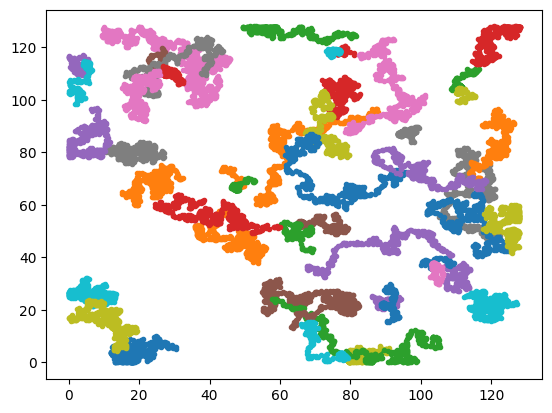

In [ ]:
#| hide
#|eval: false
for traj in np.moveaxis(trajs_test, 0, 1):
    plt.plot(traj[:,0], traj[:,1], '.-')
plt.show()

In [ ]:
#| hide
#| eval: false
video = transform_to_video(
    trajs_test,
    motion_blur_generator=MB,
    # with_masks = True,
    # motion_blur_generator=MB,
    # optics_props={"NA": 1.46,
    #               "wavelength":500e-9},
    # particle_props={"particle_intensity": [100, 0]},
    # get_vip_particles= [1,2,3],
    # background_props={"background_mean":0, "background_std":0},
    # save_video=True, path = 'video_test.tiff', with_masks = False
)

video.shape

In [ ]:
#| hide
#|eval: false
play_video(video)

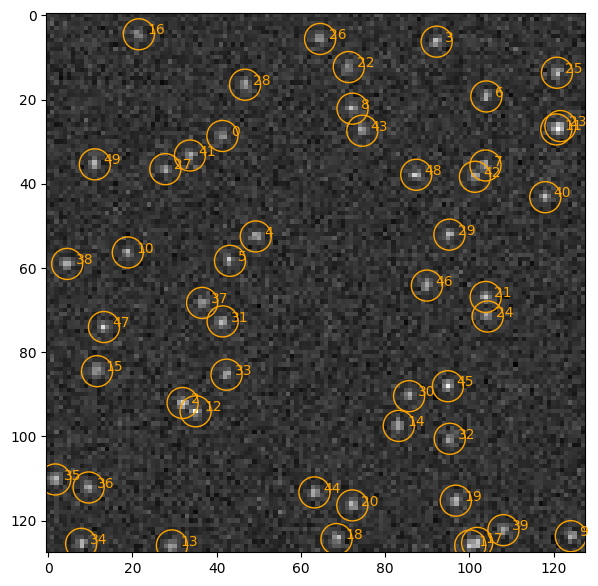

In [ ]:
#| hide
#|eval: false
detections = np.array(video[1].get_property("position", get_one=False))
plt.figure(figsize=(7,7))
plt.imshow(video[1], cmap="gray")
plt.scatter(detections[:,1], detections[:,0], marker='o', s=500, facecolors="none", edgecolors="orange")
[plt.text(y+2, x, str(i), color="orange") for i, (x, y) in enumerate(detections)]
plt.show()

In [ ]:
#| hide
def croppedimage(image, position, window=20):
    [a, b, c, d] = [
        int(position[0] - window),
        int(position[0] + window),
        int(position[1] - window),
        int(position[1] + window),
    ]
    return image[c:d, a:b]

In [ ]:
#| hide
#|eval: false
crop = croppedimage(video[0], list(reversed(detections[46])), window=8)

<matplotlib.colorbar.Colorbar>

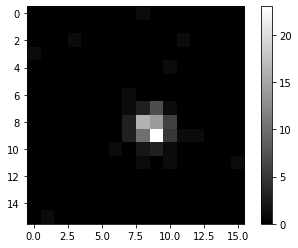

In [ ]:
#| hide
#|eval: false
plt.imshow(crop, cmap="gray")
plt.colorbar()

## Usage example
Please check tutorials for more detailed examples

Import packages

In [ ]:
from andi_datasets.models_phenom import models_phenom

Generating trajectories and passing them through `transform_to_video` to generate videos

In [ ]:
#|eval: false
trajs_test, _ = models_phenom().single_state(N = 50, T = 100, L = 128, Ds = 1)
video, masks = transform_to_video(trajs_test,
                                  with_masks=True,
                                  get_vip_particles=np.arange(55).tolist(),
                                  particle_props = {"z": lambda: 0 + np.random.rand() * 1},
                                  background_props = {"background_mean": 0,
                                                      "background_std": 0}, 
                                 optics_props = {'origin': [0,0,20,20]})

Play generated video in jupyter notebook

In [ ]:
#|eval: false
play_video(video)

Plot the first frames of the video and the masks

Text(0.5, 1.0, 'Mask 0')

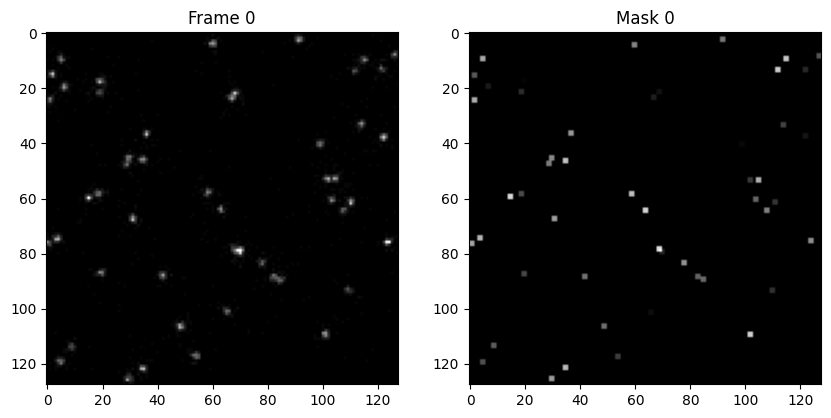

In [ ]:
#|eval: false
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
img2 = ax1.imshow(video[1], cmap="gray")
ax1.set_title("Frame 0")
ax2.imshow(masks[1], cmap="gray")
ax2.set_title("Mask 0")

Overlay trajectories on the first frame of the video

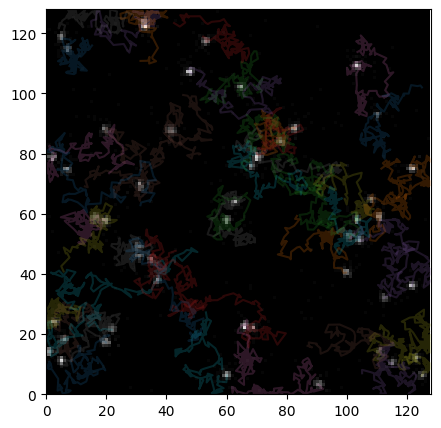

In [ ]:
#|eval: false
plt.figure(figsize=(5, 5))
plt.imshow(video[0], cmap="gray", zorder = -1)
for traj in np.moveaxis(trajs_test, 0, 1):
    plt.plot(traj[:,1], traj[:,0], alpha=0.2)
plt.xlim(0,L); plt.ylim(0,L)
plt.show()


#| hide
# Nbdev

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()